In [1]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib as mpl
from datetime import datetime
import plotly.express as px
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout


In [2]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
ls'/content/gdrive/My Drive/Thesis'

dataframe_dma_flow_1D.csv     dataframe_flow_variable_1D.csv
dataframe_dma_flow_60min.csv  dataframe_flow_variable_60min.csv
dataframe_flow_1D.csv         DMA_225.csv


In [4]:
data = pd.read_csv("/content/gdrive/My Drive/Thesis/DMA_225.csv")
data['Date-time'] = pd.to_datetime(data['Date-time'], dayfirst=True, errors='coerce')

In [5]:
data.rename( columns={'Flow':'DMA_225','Date-time':'Date_time'}, inplace=True )

In [6]:
data_DMA225 = data[['Date_time','DMA_225']]

In [7]:
data_DMA225_indexed = data_DMA225.set_index('Date_time')

In [8]:
data_DMA225_indexed.shape

(35040, 1)

In [9]:
# Sampling the data into daily sum.
dd = data_DMA225_indexed.resample('D').sum()
dd.shape

(365, 1)

In [10]:
values = dd.values

In [11]:
# Splitting train and test set.
train_size = int(len(values) * 0.70)
test_size = len(values) - train_size
train, test = values[0:train_size,:], values[train_size:len(values),:]
print(len(train), len(test))

255 110


In [12]:
# Converting numpy array into matrix:
def matrix_dataset(array_dataset, timesteps=1):
 mat_X, mat_Y = [], []
 for i in range(len(array_dataset)-timesteps-1):
  Z = i+timesteps
  m = array_dataset[i:Z, 0]
  mat_X.append(m)
  n = array_dataset[Z, 0]
  mat_Y.append(n)
 return np.array(mat_X), np.array( mat_Y)

In [13]:
# Standardisation of the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_val = scaler.fit_transform(train)
test_val = scaler.fit_transform(test)

# Look_back : t-6, t-5, t-4, t-3, t-2, t-1 and t  to calculate t+1 (single step prediction)
look_back = 7
X_train, Y_train = matrix_dataset(train_val, look_back)
X_test, Y_test = matrix_dataset(test_val, look_back)

In [14]:
# reshape input to be [samples, time_steps, features]
time_steps = 1 # single-step prediction
features = 1
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#X_train = np.reshape(X_train, (X_train.shape[0],1,1))
#X_test = np.reshape(X_test, (X_test.shape[0],1,1))

In [15]:
X_train.shape

(247, 7, 1)

In [16]:
X_test.shape

(102, 7, 1)

In [17]:
# LSTM model
model = tf.keras.Sequential()
model.add(LSTM(6,input_shape=(7,1)))
model.add(Dropout(0.8))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, Y_train, validation_data=(X_test,Y_test),shuffle=False, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
247/247 - 3s - loss: 0.0225 - val_loss: 0.0148
Epoch 2/100
247/247 - 1s - loss: 0.0251 - val_loss: 0.0145
Epoch 3/100
247/247 - 1s - loss: 0.0175 - val_loss: 0.0134
Epoch 4/100
247/247 - 1s - loss: 0.0156 - val_loss: 0.0130
Epoch 5/100
247/247 - 1s - loss: 0.0152 - val_loss: 0.0124
Epoch 6/100
247/247 - 1s - loss: 0.0134 - val_loss: 0.0123
Epoch 7/100
247/247 - 1s - loss: 0.0144 - val_loss: 0.0115
Epoch 8/100
247/247 - 1s - loss: 0.0124 - val_loss: 0.0112
Epoch 9/100
247/247 - 1s - loss: 0.0116 - val_loss: 0.0111
Epoch 10/100
247/247 - 1s - loss: 0.0132 - val_loss: 0.0112
Epoch 11/100
247/247 - 1s - loss: 0.0115 - val_loss: 0.0106
Epoch 12/100
247/247 - 1s - loss: 0.0111 - val_loss: 0.0101
Epoch 13/100
247/247 - 1s - loss: 0.0121 - val_loss: 0.0098
Epoch 14/100
247/247 - 1s - loss: 0.0101 - val_loss: 0.0099
Epoch 15/100
247/247 - 1s - loss: 0.0124 - val_loss: 0.0107
Epoch 16/100
247/247 - 1s - loss: 0.0120 - val_loss: 0.0102
Epoch 17/100
247/247 - 1s - loss: 0.0121 - val_lo

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6)                 192       
_________________________________________________________________
dropout (Dropout)            (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Generate predictions
train_pred = model.predict(X_train)
evaluation = model.evaluate(x=X_test, y=Y_test, verbose=1)
test_pred = model.predict(X_test)

4/4 [==============================] - 0s 5ms/step - loss: 0.0099


In [20]:
# De-standardising the output to original value
train_pred = scaler.inverse_transform(train_pred)
Y_train = scaler.inverse_transform([Y_train])
test_pred = scaler.inverse_transform(test_pred)
Y_test = scaler.inverse_transform([Y_test])
predictions = test_pred

In [21]:
# Calculating RMSE
import math
from sklearn.metrics import mean_squared_error
trainset = math.sqrt(mean_squared_error(Y_train[0],train_pred[:,0]))
testset = math.sqrt(mean_squared_error(Y_test[0],test_pred[:,0]))

print("The RMSE prediction value on trainset: ",trainset)
print("The RMSE prediction value on testset: ",testset)

The RMSE prediction value on trainset:  81.10061778076827
The RMSE prediction value on testset:  95.92492530284059


In [22]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

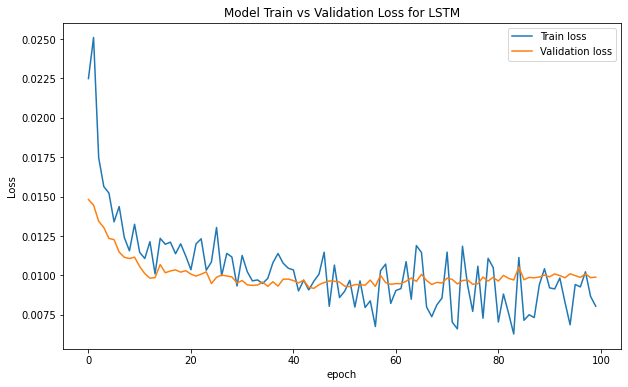

In [23]:
plot_loss(history,'LSTM')